# Preconditioner Series: Cholesky Decomposition

In this notebook, we implement our own Cholesky decomposition algorithm and compare its performance to NumPy's implementation. We also explore variants of the Cholesky decomposition such as:
- Incomplete Cholesky factorization
- LDL
- Cholesky-Banachiewicz factorization
- Cholesky-Crout factorization

## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
from numpy.linalg import cholesky
from sksparse.cholmod import cholesky as sp_cholesky
from numba import jit

ImportError: dlopen(/Users/Shion/anaconda3/envs/num-lin-alg/lib/python3.5/site-packages/sksparse/cholmod.cpython-35m-darwin.so, 2): Library not loaded: @rpath/libcholmod.3.0.11.dylib
  Referenced from: /Users/Shion/anaconda3/envs/num-lin-alg/lib/python3.5/site-packages/sksparse/cholmod.cpython-35m-darwin.so
  Reason: image not found

## What is it?

The Cholesky decomposition offers an efficient method to calculate numerical solutions to linear equations $Ax=b$ when $A$ is **symmetric (Hermitian if complex)** and **positive definite**. When this is the case, we can decompose $A$ into two matrices:
$$ A=LL^* $$

where $L$ is a lower triangular matrix with real, positive diagonal entries, and $L^*$ is the conjugate transpose of $L$. In the case that $A$ is symmetric and positive definite, $L^*=L^T$.

## Why do it?

When solving linear equations $Ax=b$, the Cholesky decomposition breaks down $Ax=b$ into easier problems. Here are the steps:

1. Cholesky decomposition:  $$ A=LL^* $$
2. Substitute $LL^*$ for $A$:  $$ Ax=LL^*x=b $$
3. Create a new variable $y$:  $$ y=L^*x $$
4. Substitute $y$ into equation from (2) and solve for $y$:  $$ Ly=b $$
5. Solve for $x$:  $$ L^*x=y $$

The efficiency of this method stems from the fact that $L$ and $L^*$ are both triangular matrices, which means that steps 4 and 5 can be performed efficiently.

## How do we do it?

The algorithm for the Cholesky decomposition is quite simple and can be derived by writing out the decomposition with variables:

<img src="img/cholesky_deriv.png" alt="term-document matrix" style="width: 60%"/>

From the matrix above, we can derive separate formulas for the diagonals and non-diagonal elements of $L$ for $A$ with $i$ rows and $k$ columns:

$$\begin{align}
l_{kk} &= \sqrt{a_{kk}-\sum_{j=1}^{k-1}l_{kj}^2}\\
l_{ik} &= \frac{1}{l_{kk}}\bigg(a_{ik}-\sum_{j=1}^{k-1}l_{ij}l_{kj}\bigg)\ \ \ ,\text{where}\ i>k
\end{align}$$

## Cholesky decomposition from scratch

In [76]:
def my_cholesky(A):
    rows, cols = A.shape
    L = np.zeros((rows, cols))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if (i == k):
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

## Comparison to NumPy's *cholesky*

Let's first create a symmetric, positive definite matrix.

In [77]:
A = make_spd_matrix(5)
A.shape

(5, 5)

In [78]:
%time L_np = cholesky(A)
L_np

CPU times: user 68 µs, sys: 11 µs, total: 79 µs
Wall time: 82 µs


array([[ 0.90454761,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.18951394,  0.6703278 ,  0.        ,  0.        ,  0.        ],
       [ 0.50978438, -0.25497388,  0.6592427 ,  0.        ,  0.        ],
       [-0.42387228,  0.07523756,  0.32566469,  0.78363073,  0.        ],
       [ 1.4095982 , -0.86403946,  0.13473263, -0.28212476,  1.37692948]])

In [79]:
%time L = my_cholesky(A)
L, np.allclose(L, L_np)

CPU times: user 105 µs, sys: 3 µs, total: 108 µs
Wall time: 112 µs


(array([[ 0.90454761,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.18951394,  0.6703278 ,  0.        ,  0.        ,  0.        ],
        [ 0.50978438, -0.25497388,  0.6592427 ,  0.        ,  0.        ],
        [-0.42387228,  0.07523756,  0.32566469,  0.78363073,  0.        ],
        [ 1.4095982 , -0.86403946,  0.13473263, -0.28212476,  1.37692948]]),
 True)

Although my implementation of the Cholesky decomposition takes roughly 1.5 to 2 times to that of NumPy, we got the same answer. For larger matrices, my implementation still computes the answer correctly albeit a few orders of magnitude slower.

In [80]:
A = make_spd_matrix(100)
%time L_np = cholesky(A)
%time L = my_cholesky(A)
np.allclose(L_np, L)

CPU times: user 334 µs, sys: 10 µs, total: 344 µs
Wall time: 229 µs
CPU times: user 173 ms, sys: 2.32 ms, total: 175 ms
Wall time: 168 ms


True

Let's try speeeding things up with Numba's @jit decorator.

In [86]:
@jit
def my_cholesky_jit(A):
    rows, cols = A.shape
    L = np.zeros((rows, cols))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if (i == k):
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

In [87]:
%time L_jit = my_cholesky_jit(A)

AssertionError: Failed at object (object mode frontend)


## Variants to the Cholesky decomposition

### Incomplete Cholesky factorization

Of course, like any decomposition algorithm in numerical linear algebra, the Cholesky decomposition has a variation that calculates a sparse approximation of it.

$$ A\approx KK^* $$

In [88]:
def my_ichol(A, mode):
    rows, cols = A.shape
    K = zeros((rows, cols))
    
    if mode == 0:
        K[0, 0] = np.sqrt(A[0, 0])
    
        for i in range(1, rows):
            for k in range(i + 1):
                if (A[i, k] != 0):
                    if (i == k):
                        K[i, k] = np.sqrt(A[i, k] - sum([K[k, j] ** 2 for j in range(k)]))
                    else:
                        K[i, k] = (K[i, k] - sum([K[i, j] * K[k, j] for j in range(k)])) / K[k, k]
        
    return K

In [12]:
A = make_spd_matrix(10)

#### Comparison with *scikit.sparse* implementation

As I did before, I compare the results of my function with that of a function written using the *scipy.sparse* library.

#### Comparison with (complete) Cholesky factorization

By comparing the sparsity patterns of the two methods, we can see how much memory can be saved at the expense of some accuracy.

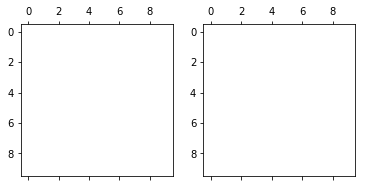

In [17]:
plt.subplot(1, 2, 1)
plt.spy(A)

plt.subplot(1, 2, 2)
plt.spy(A)

plt.show()

### LDL

## Resources

[Cholesky decomposition algorithm derivation](https://rosettacode.org/wiki/Cholesky_decomposition)

[MATLAB: Cholesky factorization](https://www.mathworks.com/help/matlab/ref/chol.html)

[MATLAB: Incomplete Cholesky factorization](https://www.mathworks.com/help/matlab/ref/ichol.html)